In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from ImageOperations import get_cropped_denoised, get_cropped, getImage, get_mask, get_ROI
from skimage.measure import points_in_poly
from skimage.morphology import extrema
import skimage as ski
import scipy.ndimage as ndi

In [231]:
def detect_points(image,ROI,ntol=10):
    ROIcoords = ROI.coordinates()-[[ROI.left,ROI.top]]
    # local_max = find_local_maxima(image)
    # y, x, regs = find_maxima(image,local_max,ntol)
    points = np.array([y,x]).T
    inCell = points_in_poly(points,ROIcoords)
    return points[inCell]


df = pd.read_excel(r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\Results.xlsx")
data = df.loc[df["Group2"]=="LC3"]

rmap = LinearSegmentedColormap.from_list(
        "Custom", 
        [(0, 0, 0), (1, 0, 0)], 
        N=255)

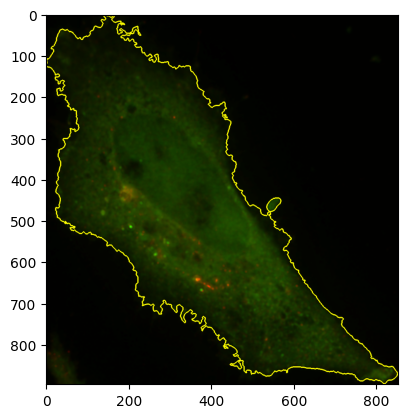

In [232]:
class RGB:
    def __init__(self, shape = None, canvas = False):
        self.colors = {"r":[0],
                       "g":[1],
                       "b":[2],
                       "y":[0,1],
                       "m":[1,2],
                       "c":[0,2],
                       "w":[0,1,2]}
        self.shape = shape
        if self.shape != None:
            if canvas == True:
                self.img = np.ones([*self.shape,3]).astype("uint8")*255
            else: 
                self.img = np.zeros([*self.shape,3]).astype("uint8")
        pass
    
    def add_image(self, image, color):
        if self.shape == None:
            self.shape = image.shape
            self.img = np.zeros(tuple([*self.shape,3])).astype("uint8")
        elif self.shape != image.shape:
            raise Exception("Shapes don't comply!")
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = ski.util.img_as_ubyte(ski.exposure.equalize_adapthist(image))
        self.img = np.max(
            np.stack([self.img, temp_img], axis = 3),
            axis = 3
        )
        return self
    
    def show(self):

        #rgb = ski.color.gray2rgb(self.img, channel_axis=2)
        plt.imshow(self.img)
        return self
    
    def save(self, filename):
        ski.io.imsave(filename, self.img)
        return self
    
    def add_boundary(self, coords, color, thickness = 1):
        coordmat = np.zeros(self.shape, dtype = bool)
        coordmat[coords.T.astype(int)[1],
                 coords.T.astype(int)[0]] = True
        coordmat = ndi.binary_dilation(coordmat, iterations = thickness).astype("uint8")*255
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = coordmat
        self.img = np.max(
            np.stack([self.img, temp_img],axis = 3),
            axis = 3
        )
        return self
    
    def draw_x(self, coords, color, radius = 5):
        coordmat = np.zeros(self.shape, dtype = bool)
        for coord in coords:
            d_r, d_c = ski.draw.disk(center = coord, radius = radius, shape = self.shape)
            l1 = ski.draw.line(np.min(d_r), np.min(d_c), np.max(d_r), np.max(d_c))
            l2 = ski.draw.line(np.max(d_r), np.min(d_c), np.min(d_r), np.max(d_c))
            coordmat[l1] = True
            coordmat[l2] = True
        coordmat = ndi.binary_dilation(coordmat, iterations = 2).astype("uint8")*255
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = coordmat
        self.img = np.max(
            np.stack([self.img, temp_img],axis = 3),
            axis = 3
        )
        return self
    
    def draw_c(self, coords, color, radius = 5):
        coordmat = np.zeros(self.shape, dtype = bool)
        for coord in coords:
            disk = ski.draw.disk(center = coord, radius = radius, shape = self.shape)
            coordmat[disk] = True
        coordmat = ndi.binary_dilation(coordmat, iterations = 1).astype("uint8")*255
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = coordmat
        self.img = np.max(
            np.stack([self.img, temp_img],axis = 3),
            axis = 3
        )
        return self


test_CID = 161
test_ROI = get_ROI(data,test_CID)
boundary = test_ROI.coordinates()-[[test_ROI.left,test_ROI.top]]
test_image_full_lc3 = np.max(get_cropped(data, test_CID, 2).astype("uint16"), axis =0)
test_image_full_ab = np.max(get_cropped(data, test_CID, 1).astype("uint16"), axis =0)

RGB().add_image(test_image_full_lc3,"r").add_image(test_image_full_ab,"g").add_boundary(boundary, "y", thickness = 1).show().save("ImageAnalysisExamples/Merged.png")


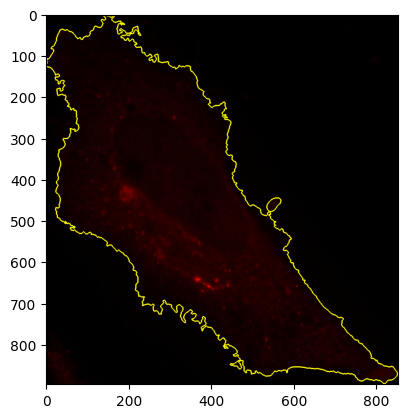

In [233]:
RGB().add_image(test_image_full_lc3,"r").add_boundary(boundary, "y", thickness = 1).show().save("ImageAnalysisExamples/LC3_full.png")

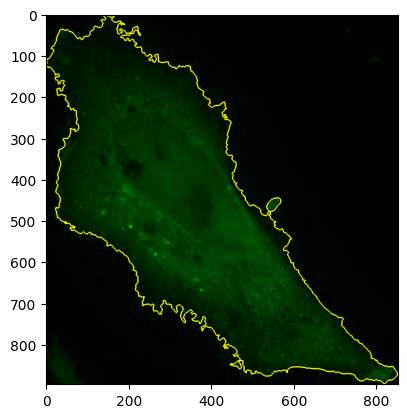

In [234]:
RGB().add_image(test_image_full_ab,"g").add_boundary(boundary, "y", thickness = 1).show().save("ImageAnalysisExamples/aSyn_full.png")

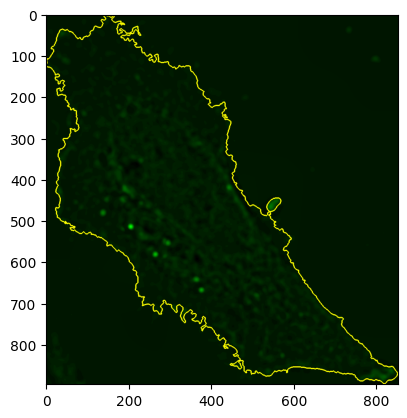

In [235]:
stack_img_lc3 = getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],2).astype("uint16")
stack_img_ab = getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],1).astype("uint16")
test_img_lc3 = np.max(getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],2).astype("uint16"), axis =0)
test_img_ab = np.max(getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],1).astype("uint16"), axis =0)
RGB().add_image(test_img_ab,"g").add_boundary(boundary, "y").show().save("ImageAnalysisExamples/aSyn_denoised.png")

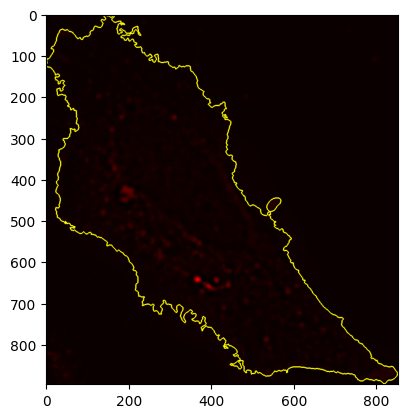

In [236]:
RGB().add_image(test_img_lc3,"r").add_boundary(boundary, "y").show().save("ImageAnalysisExamples/LC3_denoised.png")


In [237]:
# maxima_lc3 = np.stack(np.where(np.max(ski.morphology.h_maxima(stack_img_lc3,20),axis = 0))).T
# RGB().add_image(test_img_lc3,"r").add_boundary(boundary, "y").draw_x(maxima_lc3,"w", radius=10).show().save("ImageAnalysisExamples/LC3_points.png")

In [238]:
# maxima_ab = np.stack(np.where(np.max(ski.morphology.h_maxima(stack_img_ab,10),axis = 0))).T
# RGB().add_image(test_img_ab,"g").add_boundary(boundary, "y").draw_x(maxima_ab,"w", radius=10).show().save("ImageAnalysisExamples/aSyn_points.png")

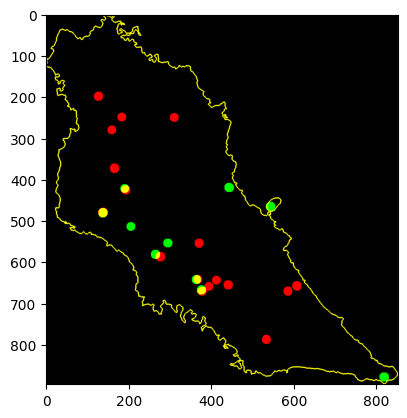

In [239]:
RGB(shape = test_img_ab.shape).add_boundary(boundary, "y").draw_c(maxima_ab,"g", radius=10).draw_c(maxima_lc3,"r", radius=10).show().save("ImageAnalysisExamples/points_only.png")

In [240]:
import os
from tqdm import tqdm

def detect_points():
    return


def get_points(data = None,
               channel_name = None,
               channel_id = None,
               height = 10,
               dir = None):
    cols = ["z","y","x"]
    for CID in tqdm(data.loc[:,"CID"]):
        celldir = os.path.join(dir,str(CID))
        if not os.path.exists(celldir):
            os.makedirs(celldir)
        image = getImage(data.loc[data["CID"]==CID,"denoised_path"].values[0],channel_id).astype("uint16")
        maxima = np.where(ski.morphology.h_maxima(image,height))
        pdf = pd.DataFrame(data = {cols[i]: v for i,v in enumerate(maxima)})
        pdf.to_csv(os.path.join(celldir,channel_name+".csv"),index=False)
    return

dir = r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\Points\LC3"
# get_points(data = data, channel_id = 1, dir = dir, channel_name="aSyn", height = 10)

In [241]:
# get_points(data = data, channel_id = 2, dir = dir, channel_name="LC3", height = 20)

In [242]:
from scipy.spatial import KDTree

def calculate_distance(X, Y):
    d,_ = KDTree(Y).query(X)
    return d

def get_d_for_cell(c_dir, ch1, ch2, plens):
    df1 = pd.read_csv(os.path.join(c_dir,ch1)+".csv")
    df2 = pd.read_csv(os.path.join(c_dir,ch2)+".csv")
    X = df1.iloc[:,:3].apply(lambda x: x*plens[x.name]).values

    Y = df2.iloc[:,:3].apply(lambda x: x*plens[x.name]).values
    d = calculate_distance(X,Y)
    return d

def calculate_NN(data, dir, channel1, channel2, plens):
    dist_df_list = []
    c = 0
    for CID in tqdm(data.loc[:,"CID"]):
        # if c > 0:
        #     continue
        # c += 1
        c_dir = os.path.join(dir,str(CID))
        d = get_d_for_cell(c_dir, channel1, channel2, plens)
        d_df = pd.DataFrame(data = {"d": d})
        d_df["CID"] = CID
        d_df["Group"] = data.loc[data["CID"]==CID,"Group1"].values[0]
        dist_df_list.append(d_df)
    NN_df = pd.concat(dist_df_list, axis = 0, ignore_index=True)
    return NN_df
    
plens = {"x": 0.07530842430163,
         "y": 0.07530842430163,
         "z": 0.2}

NN_df = calculate_NN(data,
                     dir,
                     "LC3",
                     "aSyn",
                     plens)

NN_df.head()
NN_df.to_csv(r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\LC3_distances.csv", index=False)

100%|██████████| 78/78 [00:00<00:00, 97.79it/s] 


<Axes: xlabel='d', ylabel='Density'>

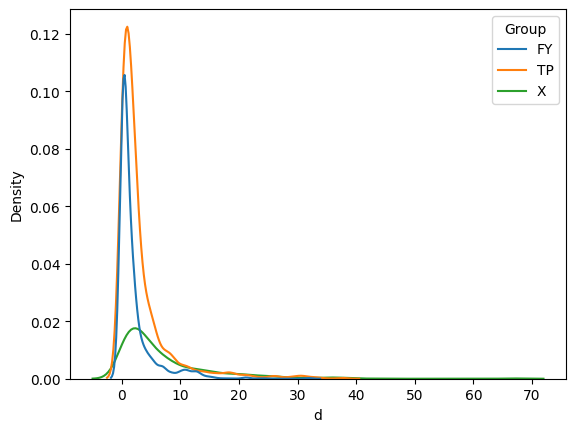

In [243]:
import seaborn as sns

sns.kdeplot(NN_df, x = "d", hue = "Group", bw_adjust=1)

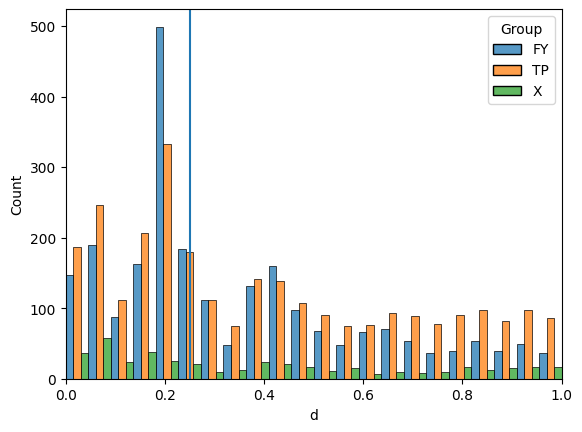

In [253]:
fig1, ax = plt.subplots()

ax = sns.histplot(NN_df, x = "d", hue = "Group", ax = ax, multiple = "dodge", binrange =(0,1))
ax.set_xlim(0,1)
ax.axvline(0.25)